# GeoProcessing with Python - Chap. 9
## Working with Raster Data

by Chris Garrand

IPython Notebooks with some additions and adaptations by Claude COULOMBE - PhD - Montréal

Source: https://github.com/cgarrard/osgeopy-code

Download the code and install it using: sudo -H pip3 install <path-to-ospybook-latest.zip>

Data: https://app.box.com/v/osgeopy

In [88]:
# I use the print function in this code, even though I don't in the book text,
# so that you can run it as a regular script and still get the output. You only
# get output without using print if you're using the interactive window.

# Set this variable to your osgeopy-data directory so that the following
# examples will work without editing. We'll use the os.path.join() function
# to combine this directory and the filenames to make a complete path. Of
# course, you can type the full path to the file for each example if you'd
# prefer.
import os
import sys
import numpy as np
from osgeo import gdal

# data_dir =
data_dir = r'/home/user/Documents/osgeopy-data/osgeopy-data/'

print("GDAL version:",gdal.__version__)

GDAL version: 2.2.3


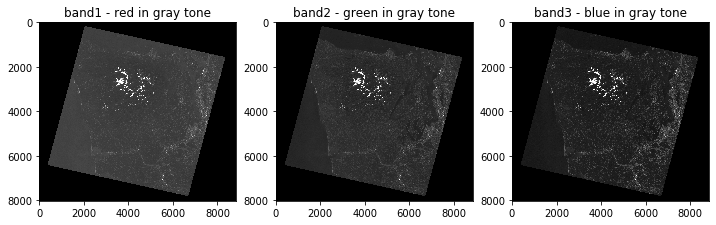

In [89]:
# Listing 9.1 - Stacking individual raster bands into one image
import os
from osgeo import gdal
# C.Coulombe add matplotlib in order to show images
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm

# Be sure to change your directory.
os.chdir(data_dir+'Landsat/Washington')
band1_fn = 'p047r027_7t20000730_z10_nn10.tif'
band2_fn = 'p047r027_7t20000730_z10_nn20.tif'
band3_fn = 'p047r027_7t20000730_z10_nn30.tif'

# C.Coulombe show raster bands in gray
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
plt.figure(figsize=(12,4))
img_band1_fn = plt.imread(band1_fn)
ax1 = plt.subplot(131)
ax1.imshow(img_band1_fn,cmap='gray',norm=NoNorm())
ax1.title.set_text("band1 - red in gray tone")
img_band2_fn = plt.imread(band2_fn)
ax2 = plt.subplot(132)
ax2.imshow(img_band2_fn,cmap='gray',norm=NoNorm())
ax2.title.set_text("band2 - green in gray tone")
img_band3_fn = plt.imread(band3_fn)
ax3 = plt.subplot(133)
ax3.imshow(img_band3_fn,cmap='gray',norm=NoNorm())
ax3.title.set_text("band3 - blue in gray tone")

# Open band 1.
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)

# Create a 3-band GeoTIFF with the same dimensions, data type, projection,
# and georeferencing info as band 1. This will be overwritten if it exists.
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('nat_color.tif',
    in_band.XSize, in_band.YSize, 3, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())

# Copy data from band 1 into the output image.
in_data = in_band.ReadAsArray()
out_band = out_ds.GetRasterBand(3)
out_band.WriteArray(in_data)

# Copy data from band 2 into the output image.
in_ds = gdal.Open(band2_fn)
out_band = out_ds.GetRasterBand(2)
out_band.WriteArray(in_ds.ReadAsArray())

# Copy data from band 3 into the output image.
out_ds.GetRasterBand(1).WriteArray(
    gdal.Open(band3_fn).ReadAsArray())

# Compute statistics on each output band.
out_ds.FlushCache()
for i in range(1, 4):
    out_ds.GetRasterBand(i).ComputeStatistics(False)

# Build overview layers for faster display.
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32])

# This will effectively close the file and flush data to disk.
del out_ds#
import os
from osgeo import gdal

# Be sure to change your directory.
os.chdir(data_dir+'/Landsat/Washington')
band1_fn = 'p047r027_7t20000730_z10_nn10.tif'
band2_fn = 'p047r027_7t20000730_z10_nn20.tif'
band3_fn = 'p047r027_7t20000730_z10_nn30.tif'

# Open band 1.
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)

# Create a 3-band GeoTIFF with the same dimensions, data type, projection,
# and georeferencing info as band 1. This will be overwritten if it exists.
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('nat_color.tif',
    in_band.XSize, in_band.YSize, 3, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())

# Copy data from band 1 into the output image.
in_data = in_band.ReadAsArray()
out_band = out_ds.GetRasterBand(3)
out_band.WriteArray(in_data)

# Copy data from band 2 into the output image.
in_ds = gdal.Open(band2_fn)
out_band = out_ds.GetRasterBand(2)
out_band.WriteArray(in_ds.ReadAsArray())

# Copy data from band 3 into the output image.
out_ds.GetRasterBand(1).WriteArray(
    gdal.Open(band3_fn).ReadAsArray())

# Compute statistics on each output band.
out_ds.FlushCache()
for i in range(1, 4):
    out_ds.GetRasterBand(i).ComputeStatistics(False)

# Build overview layers for faster display.
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32])

# This will effectively close the file and flush data to disk.
del out_ds

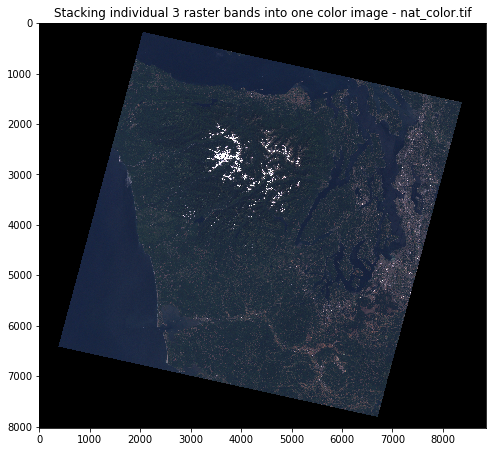

In [90]:
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
image = plt.imread('nat_color.tif')
plt.figure(figsize=(8,8))
plt.title("Stacking individual 3 raster bands into one color image - nat_color.tif")
plt.imshow(image)


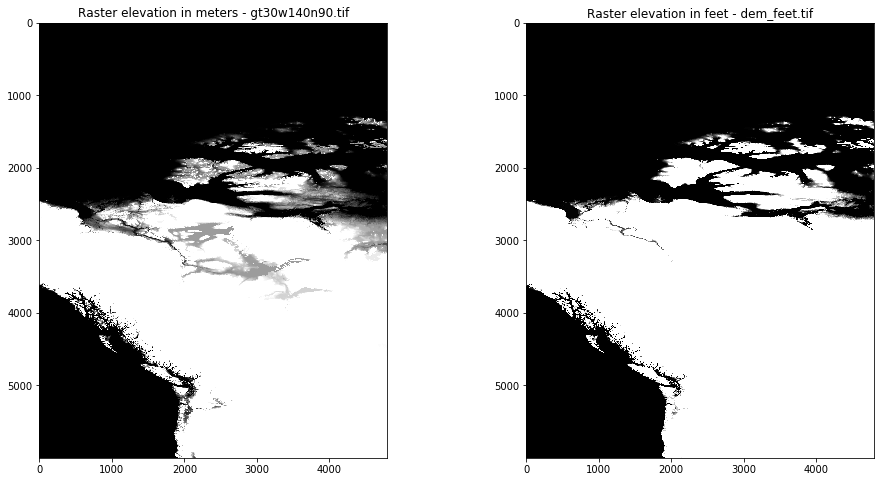

In [24]:
# Listing 9.2
# Script to convert an elevation raster from meters to feet,
# one block at a time.

import os
import numpy as np
from osgeo import gdal

# Don't forget to change your directory.
# os.chdir(r'D:\osgeopy-data\Washington\dem')
os.chdir(data_dir+'Washington/dem')

# Open the input raster and get its dimensions.
in_ds = gdal.Open('gt30w140n90.tif')

# C.Coulombe show the raster elevation in meters
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
img_in_ds = plt.imread('gt30w140n90.tif')
ax1 = plt.subplot(121)
ax1.title.set_text("Raster elevation in meters - gt30w140n90.tif")
ax1.imshow(img_in_ds)

in_band = in_ds.GetRasterBand(1)
xsize = in_band.XSize
ysize = in_band.YSize

# Get the block size and NoData value.
block_xsize, block_ysize = in_band.GetBlockSize()
nodata = in_band.GetNoDataValue()

# Create an output file with the same dimensions and data type.
out_ds = in_ds.GetDriver().Create(
    'dem_feet.tif', xsize, ysize, 1, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())
out_band = out_ds.GetRasterBand(1)

# Loop through the blocks in the x direction.
for x in range(0, xsize, block_xsize):

    # Get the number of columns to read.
    if x + block_xsize < xsize:
        cols = block_xsize
    else:
        cols = xsize - x

    # Loop through the blocks in the y direction.
    for y in range(0, ysize, block_ysize):

        # Get the number of rows to read.
        if y + block_ysize < ysize:
            rows = block_ysize
        else:
            rows = ysize - y

        # Read in one block's worth of data, convert it to feet, and then
        # write the results out to the same block location in the output.
        data = in_band.ReadAsArray(x, y, cols, rows)
        data = np.where(data == nodata, nodata, data * 3.28084)
        out_band.WriteArray(data, x, y)

# Compute statistics after flushing the cache and setting the NoData value.
out_band.FlushCache()
out_band.SetNoDataValue(nodata)
out_band.ComputeStatistics(False)
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32])
del out_ds

# C.Coulombe show the raster elevation in feet
img_out_ds = plt.imread('dem_feet.tif')
ax2 = plt.subplot(122)
ax2.title.set_text("Raster elevation in feet - dem_feet.tif")
ax2.imshow(img_out_ds)


Images above should not be different... Maybe the driver or the precision are different.

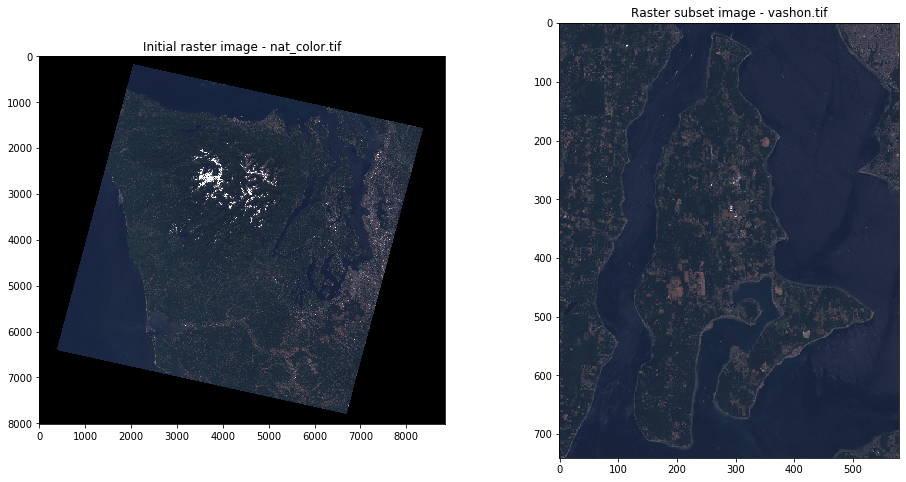

In [26]:
# Listing 9.3
# Script to extract a spatial subset from a raster.

import os
from osgeo import gdal

# Coordinates for the bounding box to extract.
vashon_ulx, vashon_uly = 532000, 5262600
vashon_lrx, vashon_lry = 548500, 5241500

# Don't forget to change the directory.
# os.chdir(r'D:\osgeopy-data\Landsat\Washington')
os.chdir(data_dir+'Landsat/Washington')
in_ds = gdal.Open('nat_color.tif')

# C.Coulombe show the initial raster image - nat_color.tif
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
img_in_ds = plt.imread('nat_color.tif')
ax1 = plt.subplot(121)
ax1.title.set_text("Initial raster image - nat_color.tif")
ax1.imshow(img_in_ds)

# Create an inverse geotransform for the raster. This converts real-world
# coordinates to pixel offsets.
in_gt = in_ds.GetGeoTransform()
inv_gt = gdal.InvGeoTransform(in_gt)
if gdal.VersionInfo()[0] == '1':
    if inv_gt[0] == 1:
        inv_gt = inv_gt[1]
    else:
        raise RuntimeError('Inverse geotransform failed')
elif inv_gt is None:
    raise RuntimeError('Inverse geotransform failed')

# Get the offsets that correspond to the bounding box corner coordinates.
offsets_ul = gdal.ApplyGeoTransform(
    inv_gt, vashon_ulx, vashon_uly)
offsets_lr = gdal.ApplyGeoTransform(
    inv_gt, vashon_lrx, vashon_lry)

# The offsets are returned as floating point, but we need integers.
off_ulx, off_uly = map(int, offsets_ul)
off_lrx, off_lry = map(int, offsets_lr)

# Compute the numbers of rows and columns to extract, based on the offsets.
rows = off_lry - off_uly
columns = off_lrx - off_ulx

# Create an output raster with the correct number of rows and columns.
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('vashon.tif', columns, rows, 3)
out_ds.SetProjection(in_ds.GetProjection())

# Convert the offsets to real-world coordinates for the georeferencing info.
# We can't use the coordinates above because they don't correspond to the
# pixel edges.
subset_ulx, subset_uly = gdal.ApplyGeoTransform(
    in_gt, off_ulx, off_uly)
out_gt = list(in_gt)
out_gt[0] = subset_ulx
out_gt[3] = subset_uly
out_ds.SetGeoTransform(out_gt)

# Loop through the 3 bands.
for i in range(1, 4):
    in_band = in_ds.GetRasterBand(i)
    out_band = out_ds.GetRasterBand(i)

    # Read the data from the input raster starting at the computed offsets.
    data = in_band.ReadAsArray(
        off_ulx, off_uly, columns, rows)

    # Write the data to the output, but no offsets are needed because we're
    # filling the entire image.
    out_band.WriteArray(data)

del out_ds

# C.Coulombe show the raster subset image - vashon.tif
img_out_ds = plt.imread('vashon.tif')
ax2 = plt.subplot(122)
ax2.title.set_text("Raster subset image - vashon.tif")
ax2.imshow(img_out_ds)


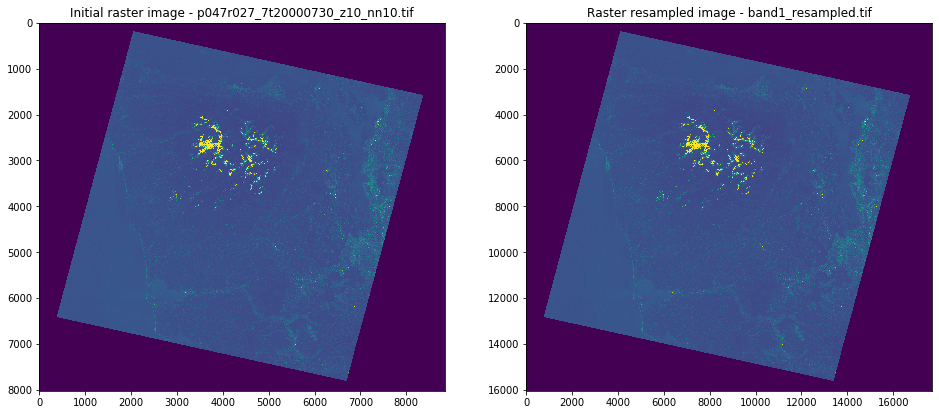

In [3]:
# Listing 9.4
# Script to resample a raster to a smaller pixel size.

import os
from osgeo import gdal

# Don't forget to change the folder.
# os.chdir(r'D:\osgeopy-data\Landsat\Washington')
os.chdir(data_dir+'Landsat/Washington')

# Open the input raster.
in_ds = gdal.Open('p047r027_7t20000730_z10_nn10.tif')
in_band = in_ds.GetRasterBand(1)

# C.Coulombe show the initial raster image - p047r027_7t20000730_z10_nn10.tif
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
plt.figure(figsize=(16,8))
img_in_ds = plt.imread('p047r027_7t20000730_z10_nn10.tif')
ax1 = plt.subplot(121)
ax1.title.set_text("Initial raster image - p047r027_7t20000730_z10_nn10.tif")
ax1.imshow(img_in_ds)

# Computer the number of output rows and columns (double the input numbers
# because we're cutting pixel size in half).
out_rows = in_band.YSize * 2
out_columns = in_band.XSize * 2

# Create the output raster using the computed dimensions.
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('band1_resampled.tif',
    out_columns, out_rows)

# Change the geotransform so it reflects the smaller cell size before
# setting it onto the output.
out_ds.SetProjection(in_ds.GetProjection())
geotransform = list(in_ds.GetGeoTransform())
geotransform[1] /= 2
geotransform[5] /= 2
out_ds.SetGeoTransform(geotransform)

# Read in the data, but have gdal resample it so that it has the specified
# number of rows and columns instead of the numbers that the input has.
# This effectively resizes the pixels.
data = in_band.ReadAsArray(
    buf_xsize=out_columns, buf_ysize=out_rows)

# Write the data to the output raster.
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(data)

# Compute statistics and build overviews.
out_band.FlushCache()
out_band.ComputeStatistics(False)
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32, 64])

del out_ds

# C.Coulombe show the raster resampled image - band1_resampled.tif
img_out_ds = plt.imread('band1_resampled.tif')
ax2 = plt.subplot(122)
ax2.title.set_text("Raster resampled image - band1_resampled.tif")
ax2.imshow(img_out_ds)


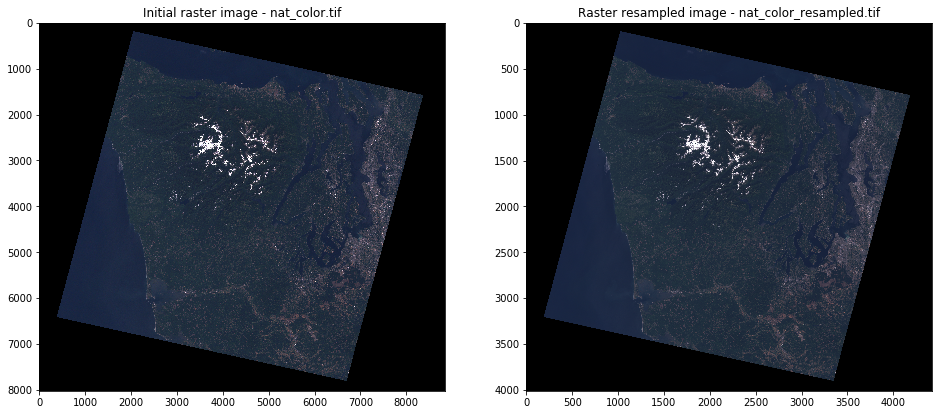

In [4]:
# Listing 9.5
# Script to resample a raster to a larger pixel size using byte sequences.

import os
import numpy as np
from osgeo import gdal

# Don't forget to change the folder.
# os.chdir(r'D:\osgeopy-data\Landsat\Washington')
os.chdir(data_dir+'Landsat/Washington')

# Open the input raster.
in_ds = gdal.Open('nat_color.tif')

# C.Coulombe show the initial raster image - nat_color.tif
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
plt.figure(figsize=(16,8))
img_in_ds = plt.imread('nat_color.tif')
ax1 = plt.subplot(121)
ax1.title.set_text("Initial raster image - nat_color.tif")
ax1.imshow(img_in_ds)

# Computer the number of output rows and columns (half the input numbers
# because we're making the pixels twice as big).
out_rows = int(in_ds.RasterYSize / 2)
out_columns = int(in_ds.RasterXSize / 2)
num_bands = in_ds.RasterCount

# Create the output raster using the computed dimensions.
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('nat_color_resampled.tif',
    out_columns, out_rows, num_bands)

# Change the geotransform so it reflects the larger cell size before
# setting it onto the output.
out_ds.SetProjection(in_ds.GetProjection())
geotransform = list(in_ds.GetGeoTransform())
geotransform[1] *= 2
geotransform[5] *= 2
out_ds.SetGeoTransform(geotransform)

# Read in the data for all bands, but have gdal resample it so that it has
# the specified number of rows and columns instead of the numbers that the
# input has. This effectively resizes the pixels.
data = in_ds.ReadRaster(
    buf_xsize=out_columns, buf_ysize=out_rows)

# Write the data to the output raster.
out_ds.WriteRaster(0, 0, out_columns, out_rows, data)

# Compute statistics and build overviews.
out_ds.FlushCache()
for i in range(num_bands):
    out_ds.GetRasterBand(i + 1).ComputeStatistics(False)
out_ds.BuildOverviews('average', [2, 4, 8, 16])

del out_ds

# C.Coulombe show the raster resampled image - nat_color_resampled.tif
img_out_ds = plt.imread('nat_color_resampled.tif')
ax2 = plt.subplot(122)
ax2.title.set_text("Raster resampled image - nat_color_resampled.tif")
ax2.imshow(img_out_ds)


#### Listing 9.6
XML describing a web map service

    <GDAL_WMS>
        <Service name="WMS">
            <Version>1.3.0</Version>
            <ServerURL>http://raster.nationalmap.gov/arcgis/services/Orthoimagery/USGS_EROS_Ortho_1Foot/ImageServer/WMSServer?</ServerURL>
            <CRS>CRS:84</CRS>
            <ImageFormat>image/png</ImageFormat>
            <Layers>0</Layers>
        </Service>
        <DataWindow>
            <UpperLeftX>-74.054444</UpperLeftX>
            <UpperLeftY>40.699167</UpperLeftY>
            <LowerRightX>-74.034444</LowerRightX>
            <LowerRightY>40.679167</LowerRightY>
            <SizeX>300</SizeX>
            <SizeY>300</SizeY>
        </DataWindow>
        <BandsCount>4</BandsCount>
    </GDAL_WMS>

In [91]:
listing9_6_xml =  '<GDAL_WMS>'+\
    '<Service name="WMS">'+\
    '<Version>1.3.0</Version>'+\
    '<ServerURL>http://oneearth.jpl.nasa.gov/wms.cgi?</ServerURL>'+\
    '<CRS>CRS:84</CRS>'+\
    '<ImageFormat>image/png</ImageFormat>'+\
    '<Layers>0</Layers>'+\
    '</Service>'+\
    '<DataWindow>'+\
    '<UpperLeftX>-74.054444</UpperLeftX>'+\
    '<UpperLeftY>40.699167</UpperLeftY>'+\
    '<LowerRightX>-74.034444</LowerRightX>'+\
    '<LowerRightY>40.679167</LowerRightY>'+\
    '<SizeX>300</SizeX>'+\
    '<SizeY>300</SizeY>'+\
    '</DataWindow>'+\
    '<BandsCount>4</BandsCount>'+\
    '</GDAL_WMS>'

In [92]:
# Get an image from a web map service using the previous XML
ds = gdal.Open(listing9_6_xml)
gdal.GetDriverByName('PNG').CreateCopy(data_dir+'liberty.png',ds)

# C.Coulombe show the downloaded image
# from matplotlib import pyplot as plt
# plt.figure(figsize=(16,8))
# image_liberty = plt.imread(data_dir+'liberty.png')
# plt.title("Liberty statue")
# plt.imshow(image_liberty)


### ***Warning ! *** The above web map service seems no more working. - C. Coulombe


In [74]:
########################  9.3 Reading partial datasets  #######################

# Open a Landsat band.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
ds = gdal.Open('p047r027_7t20000730_z10_nn10.tif')
band = ds.GetRasterBand(1)

# Read in 3 rows and 6 columns starting at row 6000 and column 1400.
data = band.ReadAsArray(1400, 6000, 6, 3)
print("data:\n",data)

# Convert the data to floating point using numpy.
data = band.ReadAsArray(1400, 6000, 6, 3).astype(float)
print("\ndata in floating point:\n",data)

# Or convert them to float by reading them into a floating point array.
data = np.empty((3, 6), dtype=float)
band.ReadAsArray(1400, 6000, 6, 3, buf_obj=data)
print("\ndata in floating point:\n",data)

# Write these few pixels to the middle of a tiny dummy raster (this
# isn't exactly like the text example because that would be hard to see
# what actually happened). You'll be able to see it best if you open the
# output in GIS software.
test_ds = gdal.GetDriverByName('GTiff').Create('test.tif', 10, 10)
band2 = test_ds.GetRasterBand(1)
band2.WriteArray(data, 4, 6)
del test_ds


data:
 [[68 70 69 67 67 67]
 [69 69 69 66 67 73]
 [67 67 65 67 70 69]]

data in floating point:
 [[68. 70. 69. 67. 67. 67.]
 [69. 69. 69. 66. 67. 73.]
 [67. 67. 65. 67. 70. 69.]]

data in floating point:
 [[68. 70. 69. 67. 67. 67.]
 [69. 69. 69. 66. 67. 73.]
 [67. 67. 65. 67. 70. 69.]]


In [76]:
########################  Access window out of range  #########################

# Try reading 5 rows and columns from the test image you just made, but
# start at row 8 and column 2. This will fail because it's trying to read
# rows 8 through 13, but there are only 10 rows.
ds = gdal.Open('test.tif')
band = ds.GetRasterBand(1)
data = band.ReadAsArray(8, 2, 5, 5)

# What happens if you try to write more data than there is room for? First
# create an array of fake data.
data = np.reshape(np.arange(25), (5,5))
print("array of fake data:\n",data)

# Now try to write it into the same area we just failed to read data from.
# That fails, too.
band.WriteArray(data, 8, 2)


array of fake data:
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


ValueError: array larger than output file, or offset off edge

### The above error is expected...

In [77]:
#####################  9.3.1 Using real-world coordinates  ####################

# Get the geotransform from one of the Landsat bands.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
ds = gdal.Open('p047r027_7t20000730_z10_nn10.tif')
band = ds.GetRasterBand(1)
gt = ds.GetGeoTransform()
print("gt:\n",gt)

# Now get the inverse geotransform. The original can be used to convert
# offsets to real-world coordinates, and the inverse can be used to convert
# real-world coordinates to offsets.

# GDAL 1.x: You get a success flag and the geotransform.
# C.Coulombe - Deprecated API - now working with GDAL 2.x
# success, inv_gt = gdal.InvGeoTransform(gt)

# GDAL 2.x: You get the geotransform or None
inv_gt = gdal.InvGeoTransform(gt)

# Use the inverset geotransform to get some pixel offsets from real-world
# UTM coordinates (since that's what the Landsat image uses). The offsets
# are returned as floating point.
offsets = gdal.ApplyGeoTransform(inv_gt, 465200, 5296000)
print("\noffsets:\n",offsets)

# Convert the offsets to integers.
xoff, yoff = map(int, offsets)
print("\nxoff, yoff:\n",xoff, yoff)

# And use them to read a pixel value.
value = band.ReadAsArray(xoff, yoff, 1, 1)[0,0]
print("\npixel value:\n",value)

# Reading in one pixel at a time is really inefficient if you need to read
# a lot of pixels, though, so here's how you could do it by reading in all
# of the pixel values first and then pulling out the one you need.
data = band.ReadAsArray()
x, y = map(int, gdal.ApplyGeoTransform(inv_gt, 465200, 5296000))
value = data[yoff, xoff]
print("\npixel value:\n",value)


gt:
 (343724.25, 28.5, 0.0, 5369585.25, 0.0, -28.5)

offsets:
 [4262.307017543859, 2581.9385964912362]

xoff, yoff:
 4262 2581

pixel value:
 62

pixel value:
 62


In [78]:
############################  9.3.2 Resampling data  ##########################

# Get the first band from the raster created with listing 8.1.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
ds = gdal.Open('nat_color.tif')
band = ds.GetRasterBand(1)

# Read in 2 rows and 3 columns.
original_data = band.ReadAsArray(1400, 6000, 3, 2)
print("original_data:\n",original_data)

# Now resample those same 2 rows and 3 columns to a smaller pixel size by
# doubling the number of rows and columns to read (now 4 rows and 6 columns).
resampled_data = band.ReadAsArray(1400, 6000, 3, 2, 6, 4)
print("\nresampled_data:\n",resampled_data)

# Read in 4 rows and 6 columns.
original_data2 = band.ReadAsArray(1400, 6000, 6, 4)
print("\noriginal_data2:\n",original_data2)

# Now resample those same 4 rows and 6 columns to a larger pixel size by
# halving the number of rows and columns to read (now 2 rows and 3 columns).
# C. Coulombe - Should be np.int32 not np.int
# resampled_data2 = np.empty((2, 3), np.int)
resampled_data2 = np.empty((2, 3), np.int32)
band.ReadAsArray(1400, 6000, 6, 4, buf_obj=resampled_data2)
print("\nresampled_data2:\n",resampled_data2)


original_data:
 [[28 29 29]
 [28 30 29]]

resampled_data:
 [[28 28 29 29 29 29]
 [28 28 29 29 29 29]
 [28 28 30 30 29 29]
 [28 28 30 30 29 29]]

original_data2:
 [[28 29 29 27 25 25]
 [28 30 29 25 32 28]
 [27 27 28 30 25 29]
 [26 26 27 30 25 30]]

resampled_data2:
 [[28 28 28]
 [28 28 28]]


In [79]:
#############################  9.4 Byte sequences  ############################

# Read a few pixels as a byte string from the raster created with listing 8.1.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
ds = gdal.Open('nat_color.tif')
data = ds.ReadRaster(1400, 6000, 2, 2, band_list=[1])
print("few pixels, data:\n",data)

# Pull the first value out. It will be converted from a byte string to a number.
print("\nthe first value, data[0]:\n",data[0])


few pixels, data:
 b'\x1c\x1d\x1c\x1e'

the first value, data[0]:
 28


In [80]:
# Try to change the value of that first pixel. This will fail because you
# can't change byte strings.
data[0] = 50


TypeError: 'bytes' object does not support item assignment

### The above error is expected...

bytearray_data[0]:
 50

tuple_data:
 (28, 29, 28, 30)

numpy_data1:
 [28 29 28 30]

numpy_data2:
 [28 29 28 30]

reshaped_data:
 [[28 29]
 [28 30]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


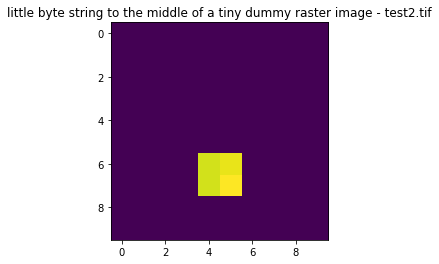

In [85]:
# Convert the byte string to a byte array and then change the first value.
bytearray_data = bytearray(data)
bytearray_data[0] = 50
print("bytearray_data[0]:\n",bytearray_data[0])

# Convert the byte string to tuple of pixel values.
import struct
tuple_data = struct.unpack('B' * 4, data)
print("\ntuple_data:\n",tuple_data)

# Convert the tuple to a numpy array.
numpy_data1 = np.array(tuple_data)
print("\nnumpy_data1:\n",numpy_data1)

# Conver the byte string to a numpy array.
numpy_data2 = np.fromstring(data, np.int8)
print("\nnumpy_data2:\n",numpy_data2)

# Reshape one of the numpy arrays so it has 2 rows and 2 columns, just like
# the original data we read in.
reshaped_data = np.reshape(numpy_data2, (2,2))
print("\nreshaped_data:\n",reshaped_data)

# Write our little byte string to the middle of a tiny dummy raster (this
# isn't exactly like the text example because that would be hard to see
# what actually happened). You'll be able to see it best if you open the
# output in GIS software.
test_ds = gdal.GetDriverByName('GTiff').Create('test2.tif', 10, 10)
test_ds.WriteRaster(4, 6, 2, 2, data, band_list=[1])
del test_ds

# C. Coulombe - show the test2.tif image
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
image = plt.imread('test2.tif')
plt.title("little byte string to the middle of a tiny dummy raster image - test2.tif")
plt.imshow(image)

In [86]:
###############################  9.5 Subdatasets  #############################

# Get the subdatasets from a MODIS file.
os.chdir(os.path.join(data_dir, 'Modis'))
ds = gdal.Open('MYD13Q1.A2014313.h20v11.005.2014330092746.hdf')
subdatasets = ds.GetSubDatasets()
print('Number of subdatasets: {}'.format(len(subdatasets)))
for sd in subdatasets:
    print('Name: {0}\nDescription:{1}\n'.format(*sd))

# Open the the first subdataset in the Modis file.
ndvi_ds = gdal.Open(subdatasets[0][0])

# Make sure that it worked by by printing out the dimensions. You can use
# ndvi_ds just like any other dataset.
print('Dataset dimensions: {} {}'.format(ndvi_ds.RasterXSize, ndvi_ds.RasterYSize))

# For example, you still need to get the band before you can read data.
ndvi_band = ndvi_ds.GetRasterBand(1)
print('Band dimensions: {} {}'.format(ndvi_band.XSize, ndvi_band.YSize))


Number of subdatasets: 12
Name: HDF4_EOS:EOS_GRID:"MYD13Q1.A2014313.h20v11.005.2014330092746.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NDVI
Description:[4800x4800] 250m 16 days NDVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)

Name: HDF4_EOS:EOS_GRID:"MYD13Q1.A2014313.h20v11.005.2014330092746.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days EVI
Description:[4800x4800] 250m 16 days EVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)

Name: HDF4_EOS:EOS_GRID:"MYD13Q1.A2014313.h20v11.005.2014330092746.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days VI Quality
Description:[4800x4800] 250m 16 days VI Quality MODIS_Grid_16DAY_250m_500m_VI (16-bit unsigned integer)

Name: HDF4_EOS:EOS_GRID:"MYD13Q1.A2014313.h20v11.005.2014330092746.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days red reflectance
Description:[4800x4800] 250m 16 days red reflectance MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)

Name: HDF4_EOS:EOS_GRID:"MYD13Q1.A2014313.h20v11.005.2014330092746.hdf":MODIS_Grid_16DAY_250m

In [95]:
###################################  9.6 WMS  #################################

ds = gdal.Open(listing9_6_xml)
# gdal.GetDriverByName('PNG').CreateCopy(r'D:\Temp\liberty.png', ds)
gdal.GetDriverByName('PNG').CreateCopy(data_dir+'liberty.png',ds)

# C.Coulombe show the downloaded image
# from matplotlib import pyplot as plt
# plt.figure(figsize=(16,8))
# image_liberty = plt.imread(data_dir+'liberty.png')
# plt.title("Liberty statue")
# plt.imshow(image_liberty)


### ***Warning ! *** The above web map service seems no more working. - C. Coulombe
